Here are some notes and calculations that arose from thinking about how _good_ various shuffling techniques are for MTG. 

In [281]:
from itertools import permutations
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Setting up a deck

To simulate and visualise shuffling techniques we'll need a way of encoding the order of a deck. To do this I have just used a list with items that are either integers or strings.
- integers are arbitrarily assigned to cards that are not basic lands
- strings are used to denote basic lands by colour

In [282]:
def get_ordered_commander_library(
    n_cards: int, lands: dict[str:int]
) -> list[int|str]:
    """creates list representation of a commander library"""
    library = []
    # add basic lands
    for land, number in lands.items():
        library.extend([land]*number)
    # add other cards
    library.extend([*range(1, n_cards - len(library))])
    return library

def get_commander_library(
    n_cards: int, lands: dict[str:int], seed: int = 0
) -> list[int|str]:
    """returns a randomly shuffled commander library"""
    random.seed(seed)
    library = get_ordered_commander_library(n_cards, lands)
    random.shuffle(library)
    return library

In [283]:
# let's create a function to visualise deck order
def visualise(library: list, title: str = None, ax = None) -> None:
    """visualises library order"""
    if ax is None:
        fig, ax = plt.subplots()

    # create a bar axis with the card indecies of unique cards and a fixed
    # index for land original position doesn't matter for it.
    # land_height = max([val for val in library if isinstance(val, int)]) + 1
    land_height = -10
    bar_colours = []
    bar_heights = []
    for card in library:
        if isinstance(card, int):
            bar_colours.append('tab:purple')
            bar_heights.append(card)
        else:
            bar_colours.append(f'tab:{card}')
            bar_heights.append(land_height)
    bar_indecies = list(range(1, len(library) + 1))
    ax.bar(bar_indecies, bar_heights, color=bar_colours, width=1)

    # set up the axis labels and plot title
    ax.set_ylabel('card index')
    y_vals, y_labels = ax.get_yticks(), ax.get_yticklabels()
    for y, label in zip(y_vals, y_labels):
        if y == land_height:
            label.set_text('land')
            break
    ax.set_yticks(y_vals[1:-1])
    ax.set_yticklabels(y_labels[1:-1])
    ax.set_xlabel('current index')
    if title is not None:
        ax.set_title(title)

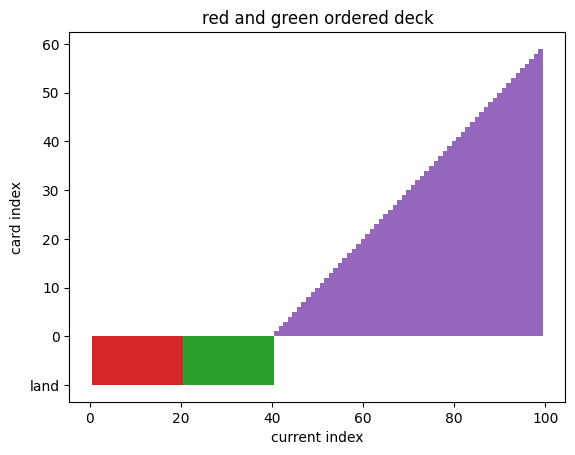

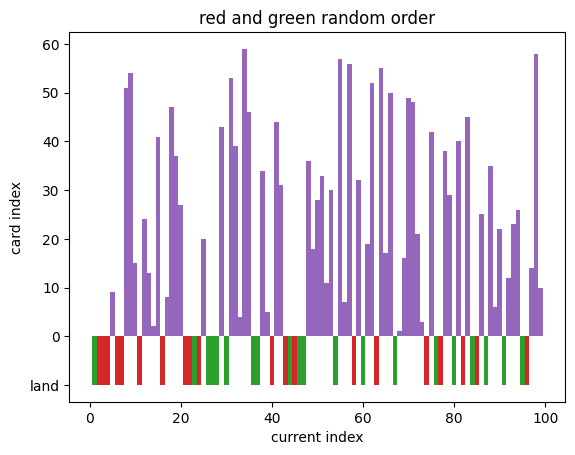

In [284]:
n_cards = 100
lands = {
    'white': 0,
    'black': 0,
    'red': 20,
    'green': 20,
    'blue': 0,
}

# generate some decks to visualise
ordered_deck = get_ordered_commander_library(n_cards, lands)
random_order = get_commander_library(n_cards, lands)

visualise(ordered_deck, title='red and green ordered deck')
visualise(random_order, title='red and green random order')

# Card proximity

One thing I think is important for a good shuffle is to move cards that were previously together away from each other.

This metric attempts to quantify that by comparing how close 2 cards are in an original and current order across the whole deck.

In [294]:
def proximity_scores(original: list, current: list) -> list[float]:
    """
    returns a score for each non-land card which shows how different the
    proximities of all other cards are to it
    """
    reduction_factor = len(original) ** 2
    scores = []
    for index, card in enumerate(original):
        # skip lands
        if not isinstance(card, int):
            scores.append(np.nan)
            continue

        # sum the absolute difference in absolute difference between indecies
        card_scores = []
        for other_card in original:
            # skip this card
            if other_card == card or not isinstance(other_card, int):
                continue
            original_delta = abs(index - original.index(other_card))
            current_delta = abs(current.index(card) - current.index(other_card))
            card_scores.append(abs(original_delta - current_delta))

        scores.append(sum(card_scores) / reduction_factor)    

    return scores


def proximity(original: list, current: list) -> float:
    """computes a metric of how different the non-land card composition is"""
    return np.nansum(proximity_scores(original, current))

Let's test this metric out using a smaller deck.

In [295]:
original = ['green', 1, 2, 3]
def proximity_key(order):
    return proximity(original, order)
orders = sorted(permutations(original, len(original)), key=proximity_key)
for order in orders:
    values = proximity_scores(original, order)
    score = proximity(original, order)
    print(f'{order=} {values=} {score=}')

order=('green', 1, 2, 3) values=[nan, 0.0, 0.0, 0.0] score=0.0
order=('green', 3, 2, 1) values=[nan, 0.0, 0.0, 0.0] score=0.0
order=(1, 2, 3, 'green') values=[nan, 0.0, 0.0, 0.0] score=0.0
order=(3, 2, 1, 'green') values=[nan, 0.0, 0.0, 0.0] score=0.0
order=('green', 1, 3, 2) values=[nan, 0.125, 0.0625, 0.0625] score=0.25
order=('green', 2, 1, 3) values=[nan, 0.0625, 0.0625, 0.125] score=0.25
order=('green', 2, 3, 1) values=[nan, 0.125, 0.0625, 0.0625] score=0.25
order=('green', 3, 1, 2) values=[nan, 0.0625, 0.0625, 0.125] score=0.25
order=(1, 'green', 2, 3) values=[nan, 0.125, 0.0625, 0.0625] score=0.25
order=(1, 'green', 3, 2) values=[nan, 0.125, 0.125, 0.0] score=0.25
order=(1, 2, 'green', 3) values=[nan, 0.0625, 0.0625, 0.125] score=0.25
order=(1, 3, 2, 'green') values=[nan, 0.125, 0.0625, 0.0625] score=0.25
order=(2, 1, 'green', 3) values=[nan, 0.0, 0.125, 0.125] score=0.25
order=(2, 1, 3, 'green') values=[nan, 0.0625, 0.0625, 0.125] score=0.25
order=(2, 3, 'green', 1) values=[nan